In [26]:
import scanpy as sc
import graph_tool.all as gt
import schist
import pandas as pd
import anndata
import mygene
import pickle
import scipy.stats
%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [18]:
sc.settings.set_figure_params(dpi=300, facecolor='white')

# NSBM correctly identifies cell populations

In [2]:
df = pd.read_table("../../../../../sc_mixology/data/csv/sc_10x_5cl.count.csv.gz", compression="gzip", sep=",")

### Preprocessing

In [3]:
adata = anndata.AnnData(df.T)
cell_cycle_genes = [x.strip() for x in open('../../../../../sc_mixology/regev_lab_cell_cycle_genes.txt')]

In [4]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

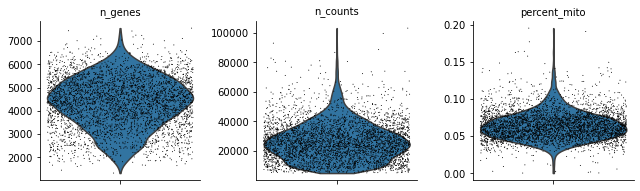

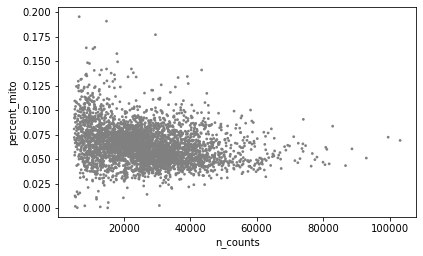

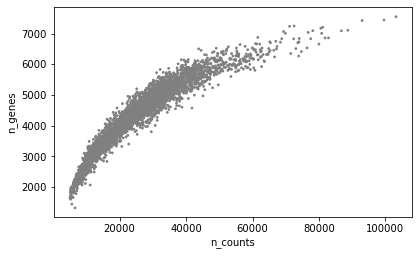

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


mito_genes = adata.var_names.str.startswith('MT-') 
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)


np.sum(adata[:, mito_genes].X, axis=1)

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)


sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')



adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [6]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

Trying to set attribute `.obs` of view, copying.


In [7]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

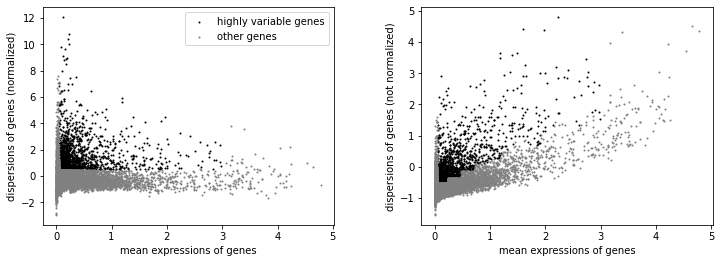

In [8]:
sc.pp.highly_variable_genes(adata, min_mean=0.05, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [9]:
adata = adata[:, adata.var['highly_variable']]

In [10]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score','n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10) #i geni con una varianza più alta di 10 gli viene attribuita varianza uguale a 10

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/anndata/_core/anndata.py:1171: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'phase' as categorical


### Cell annotation

In [11]:
cell_annotation= pd.read_table('../../../../../sc_mixology/data/csv/sc_10x_5cl.metadata.csv.gz', compression="gzip", sep=",", index_col=0)

In [17]:
adata.obs.loc[:, "cell_line_demuxlet"] = cell_annotation.loc[adata.obs_names, "cell_line_demuxlet"]

In [18]:
adata.obs.loc[:, "cell_line"] = cell_annotation.loc[adata.obs_names, "cell_line"]

### Principal component analysis and neighborhood graph computation

In [19]:
sc.tl.pca(adata, svd_solver='arpack')

In [20]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

... storing 'cell_line_demuxlet' as categorical
... storing 'cell_line' as categorical


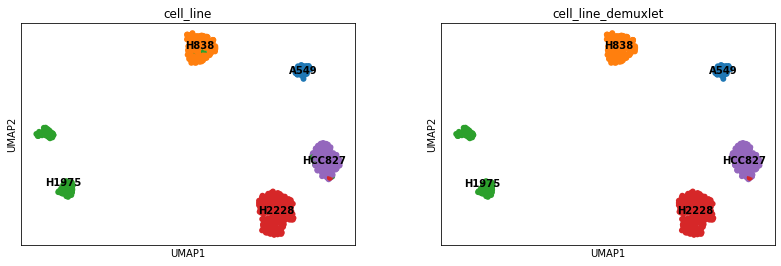

In [23]:
ciao=sc.pl.umap(adata, color=['cell_line','cell_line_demuxlet'],legend_loc='on data')

# Clustering the neighborhood graph with leiden algorithm
Clustering analysis is performed with leiden algorithm.
Changes the resolution parameter of leiden lead to changes in clustering of data: the higher the parameter, the higher the number of clusters. In order to find the best possible partition obtained through leiden algorithm we tried to set each possible value of the resolution parameter from 0.01 to 1. 

In [24]:
sc.tl.umap(adata)

In [25]:
sc.tl.leiden(adata)

If the resolution parameter is set at the default value of 1 we can observe the phenomenon of overclustering: in particular, H1975 cell-line is split into 2 clusters and  H2228 cell-line is divided into 2 separated groups. The situation remain the same for each value between 0.47 and 1

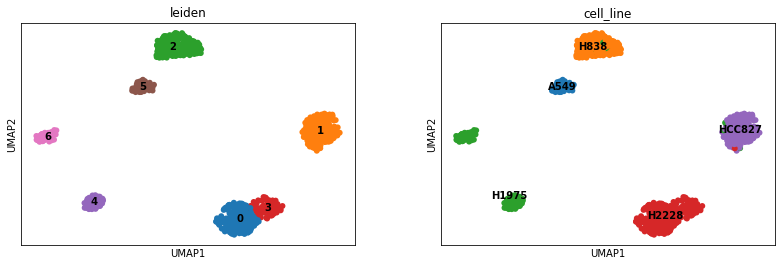

In [93]:
sc.tl.leiden(adata, resolution=1)
sc.pl.umap(adata, color=['leiden','cell_line'], legend_loc='on data')

If the resolution is set at 0.05, all cells are well classified except for H1975 cell line which is still split into 2 groups

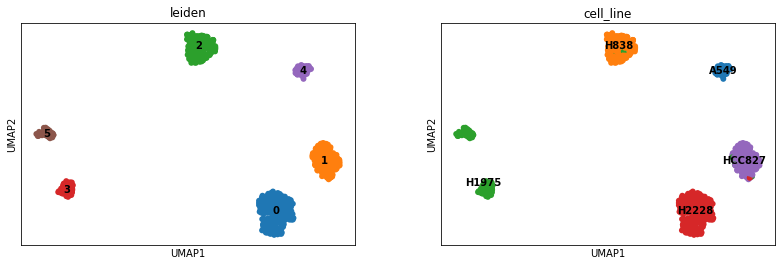

In [38]:
sc.tl.leiden(adata, resolution=0.05)
sc.pl.umap(adata, color=['leiden','cell_line'], legend_loc='on data')

Only when resolution is set at 0.04 the the clustering is completely correct

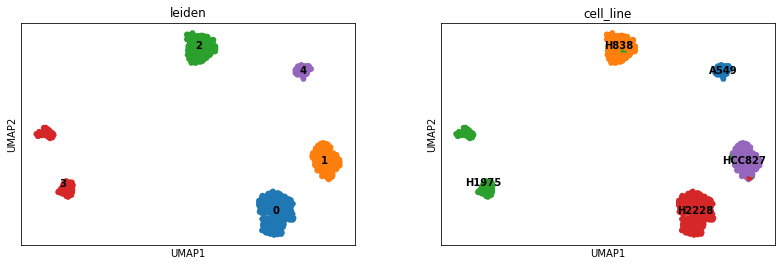

In [42]:
sc.tl.leiden(adata, resolution=0.04)
sc.pl.umap(adata, color=['leiden','cell_line'], legend_loc='on data')

In fact when the resolution is equal to 0.03,  HCC827 and A549 are merged together

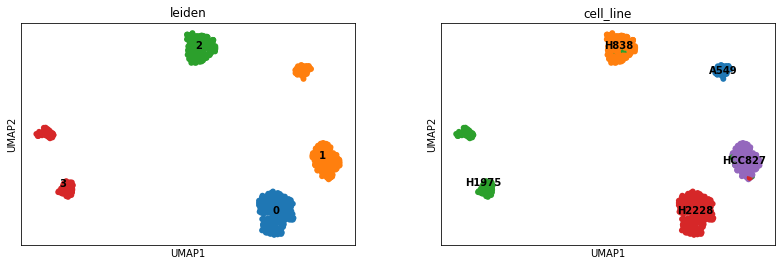

In [43]:
sc.tl.leiden(adata, resolution=0.03)
sc.pl.umap(adata, color=['leiden','cell_line'], legend_loc='on data')

# Clustering the neighborhood graph with scnsbm
clustering analysis is performed with scNSBM

In [27]:
schist.inference.nested_model(adata,equilibrate=False, deg_corr=True,use_weights=True,n_init=3)

In [35]:
schist.io.write(adata, prefix='../clustering_data/mixology10x_weighted')

In [36]:
adata=schist.io.read('../clustering_data/mixology10x_weighted')

When we have analyzed the same data with our scNSBM library, we have obtained a hierarchy of 10 levels, each one characterized by a more and more agglomerated profile and modularity measure. The selection of the right level of the hierarchy relies on the modularity measure: the level with the best clustering profile is the one with the highest modularity (Fig. 1d); in our case level 2 was the chosen one

<BarContainer object of 10 artists>

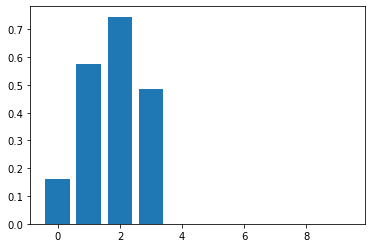

In [34]:
modularity=[x for x in adata.uns['nsbm']['stats']['modularity']]
levels=[x for x in range(len(modularity))]
bar(levels,modularity)

Clusters of level 2 respected very well resemble very precisely the ground truth

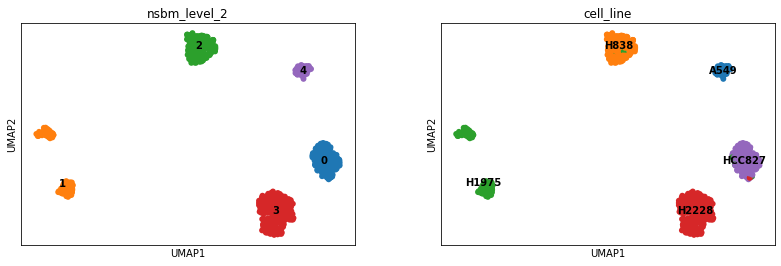

In [33]:
sc.pl.umap(adata, color=['nsbm_level_2','cell_line'], legend_loc='on data')

From these acquisitions, we can conclude that there may be an intrinsic heterogeneity inside each cell-line that could lead to the split of a cell-line in different groups; furthermore, probably A549 cells and H838 cells have some similarities. However, it is extremely difficult to obtain consistent results, due to the resolution parameter issue. On the other hand with scNSBM library the level of the hierarchy with the highest modularity measure is also the one that better explain data, according to the ground true. Moreover, similarities between cell-lines are represented at higher levels of the hierarchy. For this reason we can conclude that NSBM correctly identifies cell populations.